In [1]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale, plot_CR_CTR

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import (share_states, share_sale, env_infos, count_sales_first_session, 
                                     get_beta_confidence_interval, share_user_with_sale, share_clicks_with_sale)
# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# .reset() env before each episode (one episode per user).
env.reset()
done = False
num_products = env_1_sale_args['num_products']

In [2]:
import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np

# env_2_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.envs.utils_sale import share_states, share_sale, env_infos, count_sales_first_session

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42

# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

# # .reset() env before each episode (one episode per user).
# env.reset()
# done = False
# # Counting how many steps.
# i = 0
# observation, reward, done, info = None, 0, False, {'click':0}
# while not done:
#     action, observation, reward, done, info = env.step_offline(observation, reward, done, info)
#     print(f"Step: {i} - Action: {action} - Observation: {observation.sessions()} - Click:{observation.click} Reward: {reward}")
#     i += 1


In [3]:
num_users = 100
data = deepcopy(env).generate_logs(num_users)
display(data)
data.to_csv("generate_logs_test.csv")

Organic Users: 0it [00:00, ?it/s]
Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.10it/s]


,t,u,z,v,a,c,r,ps,ps-a
0,0.0,0,organic,0,<NA>,NaN,NaN,NaN,None
1,1.0,0,organic,9,<NA>,NaN,NaN,NaN,None
2,2.0,0,organic,0,<NA>,NaN,NaN,NaN,None
3,3.0,0,organic,0,<NA>,NaN,NaN,NaN,None
4,4.0,0,organic,9,<NA>,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...
8955,128.0,99,bandit,<NA>,2,0.0,0.0,0.1,()
8956,129.0,99,bandit,<NA>,5,0.0,0.0,0.1,()
8957,130.0,99,bandit,<NA>,2,0.0,0.0,0.1,()
8958,131.0,99,bandit,<NA>,5,0.0,0.0,0.1,()


In [4]:
# Check that we land on the clicked reco in the following organic session
ind = data[data["c"]==1].index[2]
data.iloc[ind:ind+5]

,t,u,z,v,a,c,r,ps,ps-a
203,90.0,2,bandit,<NA>,3,1.0,0.0,0.1,()
204,91.0,2,organic,3,<NA>,NaN,NaN,NaN,None
205,92.0,2,bandit,<NA>,0,0.0,0.0,0.1,()
206,93.0,2,bandit,<NA>,9,0.0,0.0,0.1,()
207,94.0,2,bandit,<NA>,5,0.0,0.0,0.1,()


In [7]:
print(share_states(data))
print("Share of users with at least one sale : ", share_user_with_sale(data))
print("Share of clicks that lead to a sale : ", share_clicks_with_sale(data))
print("\nShare of sales (binary or total) wrt nb bandit events : ",share_sale(data))
print("Share of sales among organic events :", sum(data["z"]=="sale")/sum(data["z"]=="organic"))
print("Number of sales over nb of organic events :", sum(data["r"][data['r']>0])/sum(data["z"]=="organic"))
sales, no_event = count_sales_first_session(data)
print("Share of first organic sessions with sale before reco : ",np.sum(list(sales.values()))/len(data['u'].unique()))

{'organic': 0.23649553571428572, 'bandit': 0.7444196428571429, 'sale': 0.01908482142857143}
Share of users with at least one sale :  0.54
Share of clicks that lead to a sale :  0.24358974358974358

Share of sales (binary or total) wrt nb bandit events :  {'sale_bin': 0.01664167916041979, 'sale_tot': 0.021289355322338832}
Share of sales among organic events : 0.08069844266163284
Number of sales over nb of organic events : 0.06701274185936762
Share of first organic sessions with sale before reco :  0.23


## Stats

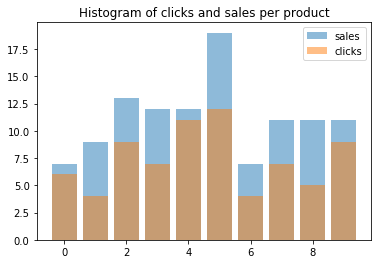

In [14]:
clicked_actions = data[data['z'] == 'bandit'].loc[data['c'] == 1]['a'] 
click_actions, total_clicks = np.unique(clicked_actions, return_counts=True)

rewarded_actions = data[data['z'] == 'bandit'].loc[data['r'] > 0]['a'] 
sale_actions, total_rewards = np.unique(rewarded_actions, return_counts=True)


plt.bar(sale_actions, total_rewards, label = "sales",alpha=0.5)
plt.bar(click_actions, total_clicks, label = "clicks",alpha=0.5)
plt.legend()
plt.title('Histogram of clicks and sales per product')
plt.show()

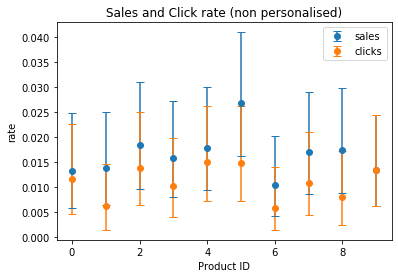

In [5]:
sales = np.zeros(num_products)
sales_tot = np.zeros(num_products)
clicks = np.zeros(num_products)
lower_errors = np.zeros(num_products)
upper_errors = np.zeros(num_products)
LB_errors = np.zeros(num_products)
UB_errors = np.zeros(num_products)
action_counts = np.unique(data[data['z'] == 'bandit']['a'], return_counts=True)[1]
actions = range(num_products)

for product_id in actions:
    n_impressions = action_counts[product_id]
    n_sales = total_rewards[product_id]
    n_clicks = total_clicks[product_id]
    
    lower_bound, upper_bound = get_beta_confidence_interval(n_impressions, n_sales)
    LB, UB = get_beta_confidence_interval(n_impressions, n_clicks)
    
    sales_tot[product_id] = n_sales
    sales[product_id] = n_sales / n_impressions
    clicks[product_id] = n_clicks / n_impressions
    
    lower_errors[product_id] = lower_bound
    upper_errors[product_id] = upper_bound
    
    LB_errors[product_id] = LB
    UB_errors[product_id] = UB

plt.title('Sales and Click rate (non personalised)')

plt.errorbar(
    actions, sales, yerr=(lower_errors, upper_errors),
    fmt='o', capsize=4, label = "sales")

plt.errorbar(
    actions, clicks, yerr=(LB_errors, UB_errors),
    fmt='o', capsize=4, label = "clicks")

plt.xlabel('Product ID')
plt.ylabel('rate')
plt.legend()
plt.show()

In [6]:
import seaborn as sns
product_views =  data[data['z'] == 'organic']['v']
products, views_counts = np.unique(product_views, return_counts=True)

In [7]:
# # With sales / nb recos

# fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# sns.regplot(views_counts, sales, ax=axes[0])
# axes[0].set_title('Sales for number of organic views')
# axes[0].set_xlabel('Number of organic views')
# axes[0].set_ylabel('Sales rate')

# sns.regplot(views_counts, clicks, ax=axes[1])
# axes[1].set_title('Clicks for number of organic views')
# axes[1].set_xlabel('Number of organic views')
# axes[1].set_ylabel('CTR')

# sns.regplot(clicks, sales, ax=axes[2])
# axes[2].set_title('Sales rate as a function of the CTR')
# axes[2].set_xlabel('CTR')
# axes[2].set_ylabel('Nb sales / Nb recos')

# plt.show()

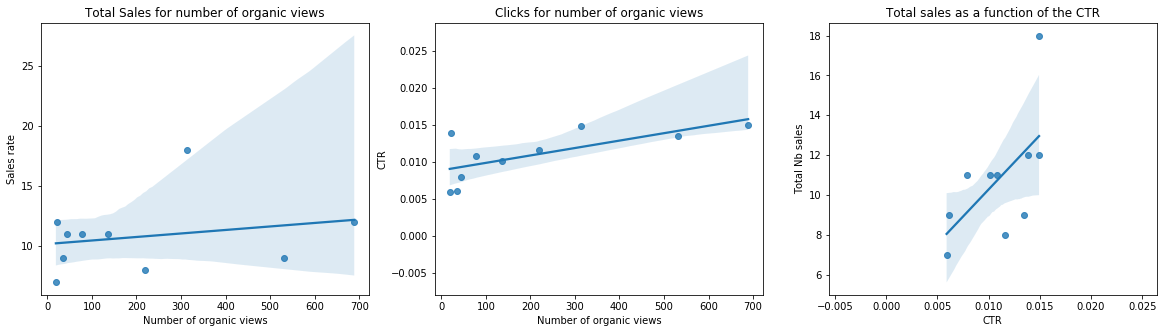

In [8]:
# With total number of sales 

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.regplot(views_counts, sales_tot, ax=axes[0])
axes[0].set_title('Total Sales for number of organic views')
axes[0].set_xlabel('Number of organic views')
axes[0].set_ylabel('Sales rate')

sns.regplot(views_counts, clicks, ax=axes[1])
axes[1].set_title('Clicks for number of organic views')
axes[1].set_xlabel('Number of organic views')
axes[1].set_ylabel('CTR')

sns.regplot(clicks, sales_tot, ax=axes[2])
axes[2].set_title('Total sales as a function of the CTR')
axes[2].set_xlabel('CTR')
axes[2].set_ylabel('Total Nb sales')

plt.show()

## Sales figures for different agents

In [6]:
from recogym.envs.utils_sale import check_sales, PopularityAgent
from recogym.agents import RandomAgent, random_args
from recogym.envs.utils_sale import SingleActionAgent

list_agents = {
    'Random': RandomAgent(Configuration({
    **env_1_sale_args,
    **random_args,
})),

    
#     'Popularity': PopularityAgent(Configuration({
#     **env_1_sale_args,
#     'num_products': num_products,
# })),
    
#     'greedy_bandit' : SingleActionAgent(np.argmax([data["r"][data['a']==a].sum() for a in range(num_products)]), 
#                                   Configuration(env_1_sale_args)),
    
    'greedy_organic' : SingleActionAgent(np.argmax(np.unique(data[data['z'] == 'organic']['v'], return_counts=True)[1]), 
                                   Configuration(env_1_sale_args))
    }

In [8]:
num_online_users = 100
list_perfs = {}
for name,agent in list_agents.items():
    print("====================================================")
    print("-------------------- " + name + " --------------------")
    print("====================================================")
    list_perfs[name] = check_sales(agent, env)
    
#     data = deepcopy(env).generate_logs(num_users, agent = agent)
#     print(share_states(data))
#     print("Share of users with at least one sale : ", share_user_with_sale(data))
#     print("Share of clicks that lead to a sale : ", share_clicks_with_sale(data))
#     print("\nShare of sales (binary or total) wrt nb bandit events : ",share_sale(data))
#     print("Share of sales among organic events :", sum(data["z"]=="sale")/sum(data["z"]=="organic"))
#     print("Number of sales over nb of organic events :", sum(data["r"][data['r']>0])/sum(data["z"]=="organic"))
#     sales, no_event = count_sales_first_session(data)
#     print("Share of first organic sessions with sale before reco : ",np.sum(list(sales.values()))/len(data['u'].unique()))

-------------------- Random --------------------
Total number of sales: 135
Share of sales (Nb sales/Nb recos): 0.0177
-------------------- greedy_organic --------------------
Total number of sales: 170
Share of sales (Nb sales/Nb recos): 0.0231


In [9]:
for name,agent in list_agents.items():
    print("====================================================")
    print("-------------------- " + name + " --------------------")
    print("====================================================")
    
    data = deepcopy(env).generate_logs(num_users, agent = agent)
    print(share_states(data))
    print("Share of users with at least one sale : ", share_user_with_sale(data))
    print("Share of clicks that lead to a sale : ", share_clicks_with_sale(data))
    print("\nShare of sales (binary or total) wrt nb bandit events : ",share_sale(data))
    print("Share of sales among organic events :", sum(data["z"]=="sale")/sum(data["z"]=="organic"))
    print("Number of sales over nb of organic events :", sum(data["r"][data['r']>0])/sum(data["z"]=="organic"))
    sales, no_event = count_sales_first_session(data)
    print("Share of first organic sessions with sale before reco : ",np.sum(list(sales.values()))/len(data['u'].unique()))

Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                   | 0/100 [00:00<?, ?it/s]

-------------------- Random --------------------


Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.29it/s]


{'organic': 0.21118917066483894, 'bandit': 0.7716758053461275, 'sale': 0.017135023989033583}
Share of users with at least one sale :  0.57
Share of clicks that lead to a sale :  0.28421052631578947

Share of sales (binary or total) wrt nb bandit events :  {'sale_bin': 0.014988342400355278, 'sale_tot': 0.01954035749972244}
Share of sales among organic events : 0.08113590263691683
Number of sales over nb of organic events : 0.07139959432048681


Organic Users: 0it [00:00, ?it/s]
Users:   0%|                                                                                   | 0/100 [00:00<?, ?it/s]

Share of first organic sessions with sale before reco :  0.2
-------------------- greedy_organic --------------------


Users: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.44it/s]


{'organic': 0.21854756222297989, 'bandit': 0.761762700306853, 'sale': 0.019689737470167064}
Share of users with at least one sale :  0.55
Share of clicks that lead to a sale :  0.291044776119403

Share of sales (binary or total) wrt nb bandit events :  {'sale_bin': 0.017231733243817837, 'sale_tot': 0.023050240572899183}
Share of sales among organic events : 0.09009360374414976
Number of sales over nb of organic events : 0.08034321372854915
Share of first organic sessions with sale before reco :  0.2


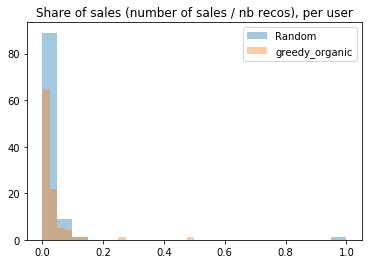

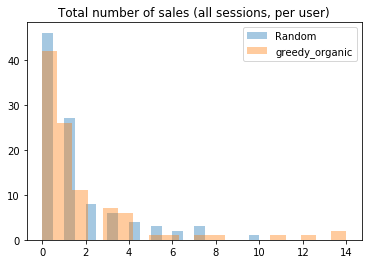

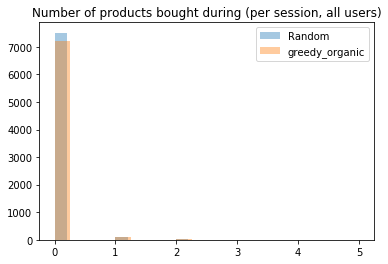

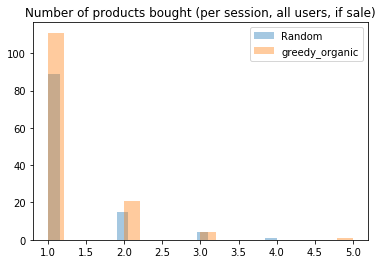

In [10]:
for name,agent in list_agents.items():
    list_sales = list_perfs[name][2]
    # Share of sales for each user (number of sales / recos)
    plt.hist([sum(list_sales[i])/len(list_sales[i]) for i in range(num_online_users)], bins=20, alpha = 0.4, label=name)
    plt.title("Share of sales (number of sales / nb recos), per user")
plt.legend()
plt.show()
    
for name,agent in list_agents.items():
    list_sales = list_perfs[name][2]
    # Total number of sales for a given user
    plt.hist([np.sum(list_sales[i]) for i in range(num_online_users)], bins=20, alpha = 0.4, label=name)
    plt.title("Total number of sales (all sessions, per user)")
plt.legend()
plt.show()
    
for name,agent in list_agents.items():
    list_sales = list_perfs[name][2]
    # Number of products bought
    all_sales = np.array([item for sublist in list_sales for item in sublist])
    plt.hist(all_sales,bins = 20, alpha = 0.4,label=name)
    plt.title("Number of products bought during (per session, all users)")
plt.legend()
plt.show()

for name,agent in list_agents.items():
    list_sales = list_perfs[name][2]
    # Number of products bought
    all_sales = np.array([item for sublist in list_sales for item in sublist])
    plt.hist(all_sales[all_sales>0],bins = 20, alpha = 0.4,label=name)
    plt.title("Number of products bought (per session, all users, if sale)")
plt.legend()
plt.show()

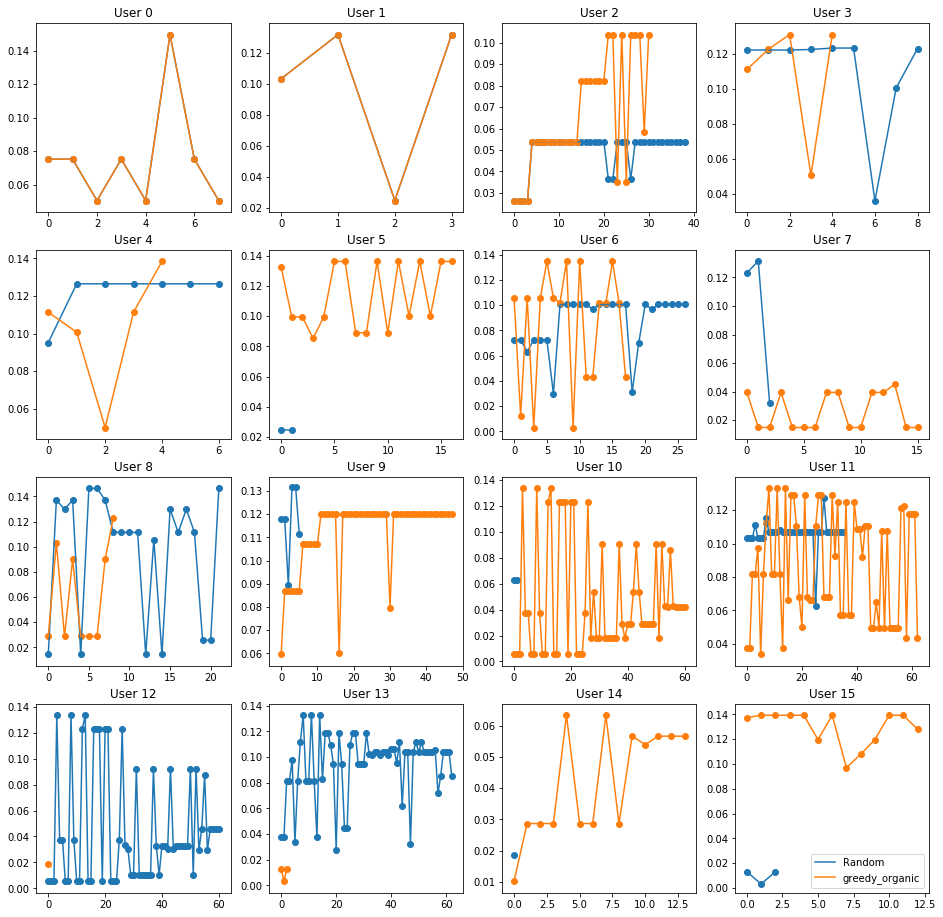

In [11]:
fig, axs = plt.subplots(4, 4, figsize = (16,16))
for i in range(4):
    for j in range(4):
        for name,agent in list_agents.items():
            list_proba_after_scaling = list_perfs[name][4]
            axs[i, j].plot(range(len(list_proba_after_scaling[i*4+j][0])),
                           list_proba_after_scaling[i*4+j][0],
                       label=name)
            axs[i, j].scatter(range(len(list_proba_after_scaling[i*4+j][0])),
                           list_proba_after_scaling[i*4+j][0])
            axs[i,j].set_title("User "+str(i*4+j))
plt.legend()
plt.show()

In [12]:
# from copy import deepcopy
result = verify_agents_sale(env, 20, list_agents)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.20it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:702: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.64it/s]
C:\Users\Philo\Documents\reco-gym\recogym\evaluate_agent_sale.py:702: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_list[agent_id] = data[data["a"] >= 0][data["c"] > 0]


In [6]:
# # Issue : takes into account all actions... Should only take into account selected actions ?


# user_inits = [env.user_embedding_list[i]["init"] for i in range(len(env.user_embedding_list))]
# user_ends = [env.user_embedding_list[i]["end"] for i in range(len(env.user_embedding_list))]
# plt.scatter([ff(user_inits[i][:,0]@env.beta[a,:]) for a in range(num_products) for i in range(len(user_inits))],
#             [env.config.psale_scale*sig(user_inits[i][:,0]@env.Lambda[a,:]) for a in range(num_products) for i in range(len(user_inits))], 
#             alpha=0.3, label='init')
# plt.scatter([ff(user_ends[i][:,0]@env.beta[a,:]) for a in range(num_products) for i in range(len(user_inits))],
#             [env.config.psale_scale*sig(user_ends[i][:,0]@env.Lambda[a,:]) for a in range(num_products) for i in range(len(user_inits))], 
#             alpha=0.3,label='end')
# plt.legend()
# plt.show()

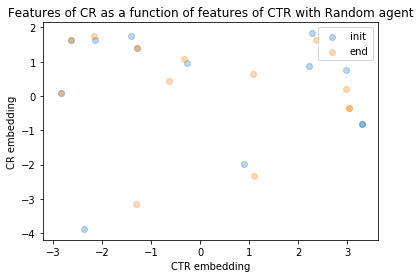

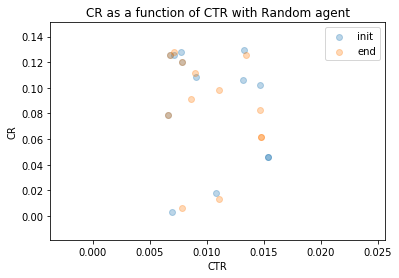

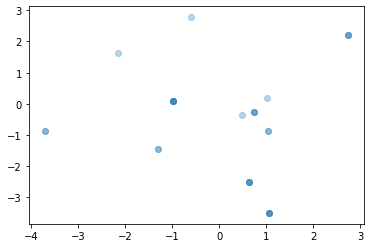

In [56]:
from recogym.envs.reco_env_v1_sale import ff, sig
plot_CR_CTR(agent="Random",result=result)
try :
    plot_CR_CTR(agent="greedy_organic",result=result)
except :
    None